In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import gym
import gym_tictactoe
from timeit import Timer
from sklearn.preprocessing import LabelBinarizer
from os import path

In [2]:
DEBUG = False

n_input = (3 * 3 * 3) * 3
n_hidden = 200
n_output = 3 * 3 * 3
learning_rate = 0.01

checkpoint_path = './checkpoints/my_dqn_tictactoe_v2_h{}_lr{}.ckpt'.format(n_hidden, learning_rate)
initializer = tf.contrib.layers.variance_scaling_initializer()

env = gym.make('tictactoe-plt-v0')
timer = Timer()

In [3]:
encoder = LabelBinarizer()
encoder.fit(np.array([[0], [1], [2]]))

def convert_game_to_x_state(obs):
    # gym_tictactoe now supports int-encoded world
    world = np.array(obs, dtype=np.float32)
    data = list(map(lambda x: [x], world.flatten()))
    return encoder.transform(data).flatten()

def convert_action_to_step(action, player):
    action = int(action)
    val = 0
    multiplier = 1
    while action:
        val += (action%3)*multiplier
        multiplier *= 10
        action //= 3
    
    return str(player) + str(val).zfill(3)

In [4]:
player_scopes = ['actor', 'critic']
all_logits = []
outputs = []
ys = []
all_network_trainable_vars_by_name = []

X_state = tf.placeholder(shape=(None, n_input), dtype=tf.float32)
global_step = tf.Variable(0, trainable=False, name='global_step')

for scope in player_scopes:
    with tf.variable_scope(scope) as tf_scope:
        hidden = fully_connected(X_state, n_hidden, activation_fn=tf.nn.relu, weights_initializer=initializer)
        logits = fully_connected(hidden, n_output, activation_fn=None, weights_initializer=initializer)
        all_logits.append(logits)

        output = tf.contrib.layers.softmax(logits)
        outputs.append(output)
        
        y = tf.to_float(tf.multinomial(tf.log(output), num_samples=n_output))
        ys.append(y)
        
        trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
        network_trainable_vars_by_name = { var.name[len(tf_scope.name):]: var for var in trainable_vars }
        all_network_trainable_vars_by_name.append(network_trainable_vars_by_name)

actor_net = outputs[0]
critic_net = outputs[1]

actor_vars = all_network_trainable_vars_by_name[0]
critic_vars = all_network_trainable_vars_by_name[1]

copy_ops = [actor_var.assign(critic_vars[var_name]) for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_net * tf.one_hot(X_action, n_output), axis=1, keepdims=True)

y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

file_writer = tf.summary.FileWriter('logs', tf.get_default_graph())
file_writer.close()

In [5]:
from collections import deque

eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 100000
replay_mem_size = 1000000
replay_mem = deque([], maxlen=replay_mem_size)


def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min)*step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_output)
    else:
        return np.argmax(q_values)

def sample_mem(batch_size):
    indices = np.random.permutation(len(replay_mem))[:batch_size]
    cols = [[], [], [], [], []]
    for idx in indices:
        memory = replay_mem[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))

In [6]:
from time import sleep

def play_with_human(env, human_starts=True):
    obs = env.reset()
    done = False
    player = 0
    human_starts_round = human_starts
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        with tf.variable_scope('actor'):
            env.render()
            while not done:
                if human_starts_round:
                    action = input()
                    step = '{}{}'.format(player%2+1, action)
                    obs, reward, done, info = env.step(step)
                    print('Human played:', step[1:])
                    env.render()
                    player += 1
#                     sleep(5)
                
                if done:
                    break

                human_starts_round=True
                state = convert_game_to_x_state(obs)
                action = np.argmax(actor_net.eval(feed_dict={X_state: [state]}))
                step = convert_action_to_step(action, player%2+1)
                obs, reward, done, info = env.step(step)
                print('Computer played:', step[1:])
                env.render()
                player += 1
            print('Game ended with reward: {}'.format(reward))

In [7]:
n_steps = 1000000
training_start = 1000
training_interval = 3
save_steps = 1000
copy_steps = 100
print_steps = 1000
discount_rate = 0.95
batch_size = 50
done = True

In [8]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    print(global_step.eval())

INFO:tensorflow:Restoring parameters from ./checkpoints/my_dqn_tictactoe_v2_h200_lr0.01.ckpt
1000000


INFO:tensorflow:Restoring parameters from ./checkpoints/my_dqn_tictactoe_v2_h200_lr0.01.ckpt


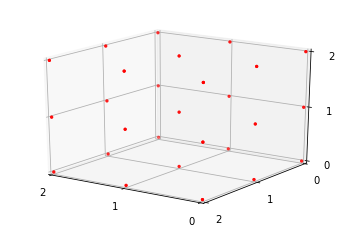

000
Human played: 000


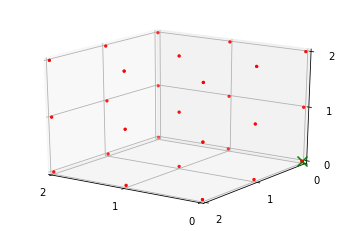

Computer played: 200


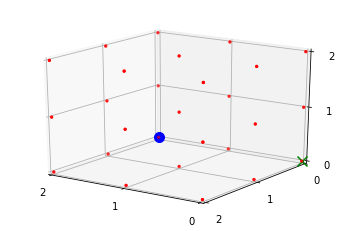

111
Human played: 111


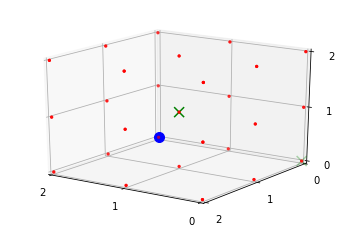

Computer played: 020


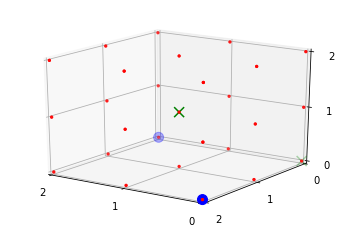

222
Human played: 222


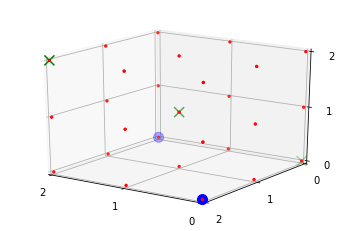

Game ended with reward: 1


In [14]:
env._close_previous_figure_before_render = True
%matplotlib inline
play_with_human(env, human_starts=False)

INFO:tensorflow:Restoring parameters from ./checkpoints/my_dqn_tictactoe_v2_h200_lr0.01.ckpt


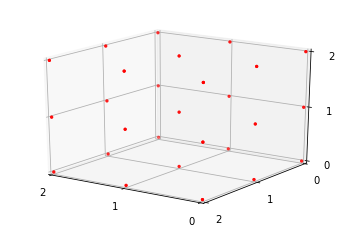

111
Human played: 111


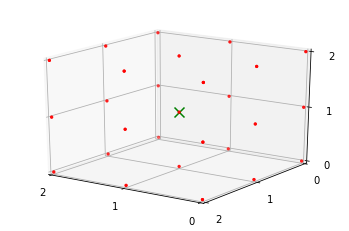

Computer played: 200


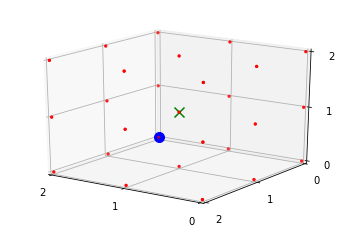

000
Human played: 000


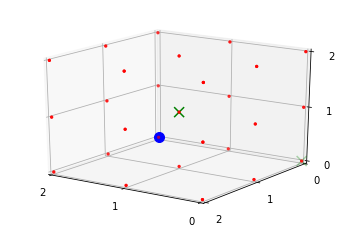

Computer played: 020


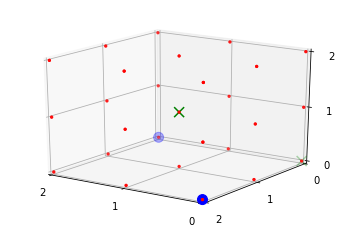

011
Human played: 011


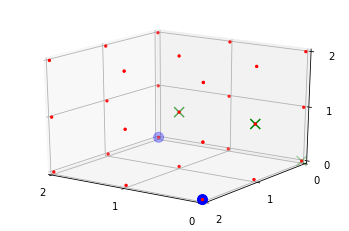

Computer played: 022


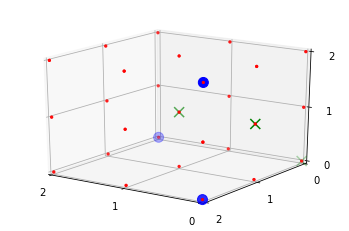

021
Human played: 021


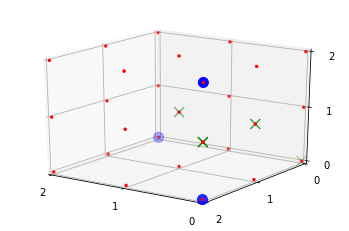

Computer played: 110


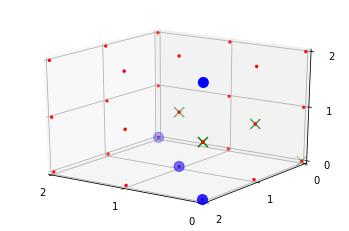

Game ended with reward: 1


In [15]:
play_with_human(env, human_starts=True)